# 機械学習帳 確認問題(8.4, 8.5)

[機械学習帳のニューラルネットワーク(2)の確認問題(8.4, 8.5)](https://chokkan.github.io/mlnote/classification/04nntrain.html#id13)を解きます。

## 講義内容の復習

![chapter8-1.svg](./images/chapter8/chapter8-1.svg)

![chapter8-2.svg](./images/chapter8/chapter8-2.svg)

## 8.4 自動微分

2次元の入力$\pmb{x} \in \mathbb{R}^{2}$を受け取り、2次元の中間層$\pmb{h} \in \mathbb{R}^{2}$を介して、$\hat{y} \in \mathbb{R}$を出力する2層のニューラルネットワークを次式で定義する。
\begin{align*}
\hat{y} = \sigma(\pmb{h}^{\top}\pmb{q}+c), \; \pmb{h}=\mathrm{ReLU}(\pmb{W}\pmb{x} + \pmb{b})
\end{align*}
ただし、$\sigma(.)$はシグモイド関数であり、$\mathrm{ReLU}(a) = \max(a, 0)$である。また、$\pmb{W} \in \mathbb{R}^{2 \times 2}, \pmb{q} \in \mathbb{R}^{2}, b \in \mathbb{R}^2, c \in \mathbb{R}$はモデルのパラメータであり、以下に示す値に設定されているとする。
\begin{align*}
\pmb{W} = \begin{pmatrix}1 & 1 \\ -1 & -1\end{pmatrix}, \; \pmb{q} = \begin{pmatrix}1 \\ 1\end{pmatrix}, \; \pmb{b} = \begin{pmatrix}-0.5 \\ 1.5\end{pmatrix}, \; c = -1.5
\end{align*}

### 8.4.1 出力の計算

このモデルに入力$\pmb{x}=\begin{pmatrix}0 \\ 0\end{pmatrix}$が与えられたとき、中間層の値$\pmb{h}$と出力値$\hat{y}$を求めよ。

In [1]:
import numpy as np
import torch


dtype = torch.float

# Variables
W = torch.tensor(np.array([[1, 1], [-1, 1]]), requires_grad=True, dtype=dtype)
b = torch.tensor(np.array([-0.5, 1.5]), requires_grad=True, dtype=dtype)
q = torch.tensor(np.array([1, 1]), requires_grad=True, dtype=dtype)
c = torch.tensor(np.array([-1.5]), requires_grad=True, dtype=dtype)

x = torch.from_numpy(np.zeros(2)).type(dtype)

# Forward
hidden = (x @ W + b).relu()
output = (hidden @ q + c).sigmoid()

print(f"hidden = {hidden}")
print(f"output = {output}")

hidden = tensor([0.0000, 1.5000], grad_fn=<ReluBackward0>)
output = tensor([0.5000], grad_fn=<SigmoidBackward0>)


### 8.4.2 勾配の計算

ある学習事例$(\pmb{x}, y) = \left(\begin{pmatrix}1 \\ 1 \end{pmatrix}, 0\right)$に対して、このニューラルネットワークをクロスエントロピー損失関数の値、および損失関数の$\pmb{W}$, $\pmb{q}$, $\pmb{b}$, $c$に関する勾配の値を求めよ。

損失関数は$- y \log p - (1 - y)\log (1-p)$であり、$y = 0$のため$-\log(1-p)$となる。

In [2]:
loss = - torch.log((torch.ones(1) - output))
print(f"loss={loss}")

loss=tensor([0.6931], grad_fn=<NegBackward0>)


In [3]:
loss.backward()
print(f"gradient W: {W.grad}")
print(f"gradient b: {b.grad}")
print(f"gradient q: {q.grad}")
print(f"gradient c: {c.grad}")

gradient W: tensor([[0., 0.],
        [0., 0.]])
gradient b: tensor([0.0000, 0.5000])
gradient q: tensor([0.0000, 0.7500])
gradient c: tensor([0.5000])


## 8.5 NNの学習

### 8.5.1 モデルの学習

MNISTの訓練データを用いて単層のニューラルネットワークを学習せよ。このとき、各エポック毎に以下の評価値を計算し、グラフとして表示せよ。

+ 訓練データ上の損失関数の値
+ 訓練データ上の正解率
+ 評価データ上の損失関数の値
+ 評価データ上の正解率

#### データの準備

MNISTのデータを準備します(6章で使用したコードを再掲)

In [4]:
import gzip
import sys
import struct
import urllib.request
from pathlib import Path
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

def openurl_gzip(url):
    request = urllib.request.Request(
        url,
        headers={
            "Accept-Encoding": "gzip",
            "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11", 
        })
    response = urllib.request.urlopen(request)
    return gzip.GzipFile(fileobj=response, mode='rb')

def save_mnist():
    if Path("data/mnist.npz").exists():
        return
    np.savez_compressed(
        "data/mnist",
        train_x=read_image(openurl_gzip("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")),
        train_y=read_label(openurl_gzip("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")),
        test_x=read_image(openurl_gzip("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")),
        test_y=read_label(openurl_gzip("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"))
    )

save_mnist()
data = np.load("data/mnist.npz")
print("Training data (X):", data["train_x"].shape, data["train_x"].dtype)
print("Training data (Y):", data["train_y"].shape, data["train_y"].dtype)
print("Test data (X):", data["test_x"].shape, data["test_x"].dtype)
print("Test data (Y):", data["test_y"].shape, data["test_y"].dtype)

Training data (X): (60000, 28, 28) float32
Training data (Y): (60000,) uint8
Test data (X): (10000, 28, 28) float32
Test data (Y): (10000,) uint8


In [5]:
num_category = 10

In [6]:
X_train = data["train_x"].reshape((data["train_x"].shape[0], -1))
Y_train = np.zeros((data["train_y"].shape[0], num_category))
Y_train[np.arange(len(data["train_y"])), data["train_y"]] = 1.0
print(X_train.shape)
print(Y_train.shape)

(60000, 784)
(60000, 10)


In [7]:
X_test = data["test_x"].reshape((data["test_x"].shape[0], -1))
Y_test = np.zeros((data["test_y"].shape[0], num_category))
Y_test[np.arange(len(data["test_y"])), data["test_y"]] = 1.0
print(X_test.shape)
print(Y_test.shape)

(10000, 784)
(10000, 10)


In [8]:
from torch.utils.data import TensorDataset


train_data = TensorDataset(
    torch.from_numpy(X_train).type(dtype),
    torch.from_numpy(Y_train).type(dtype)
)
test_data = TensorDataset(
    torch.from_numpy(X_test).type(dtype),
    torch.from_numpy(Y_test).type(dtype)
)

#### モデルの学習

In [9]:
from torch.utils.data import DataLoader


model = torch.nn.Sequential(
    torch.nn.Linear(28 * 28, 10),
    torch.nn.Softmax(dim=1)
)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loader = DataLoader(train_data, batch_size=32, shuffle=True)

history = []
for t in range(30):
    sum_loss = 0
    for x, y in loader:
        loss = loss_function(y, model(x))
        sum_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    history.append(sum_loss)

<AxesSubplot:title={'center':'loss per epoch'}>

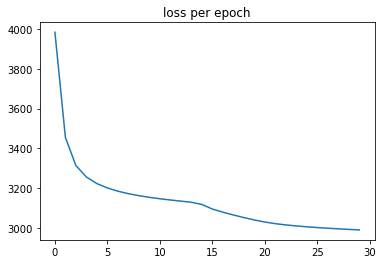

In [10]:
import pandas as pd


pd.Series(history).plot.line(title="loss per epoch")

### 8.5.2 適合率、再現率、F1スコア

(1)で学習したモデルに対して、評価データ上で以下の評価値を計算せよ。

+ 各カテゴリ（数字）に対する適合率、再現率、F1スコア
+ 各カテゴリの適合率、再現率、F1スコアのマクロ平均を取ったもの

In [11]:
from sklearn.metrics import classification_report


y_hat = None
with torch.inference_mode():
    y_proba = model(torch.from_numpy(X_test).type(dtype)).numpy()
    y_hat = np.argmax(y_proba, axis=1)
    y_max_proba = np.amax(y_proba, axis=1)

print(classification_report(data["test_y"], y_hat))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       980
           1       0.96      0.97      0.96      1135
           2       0.92      0.87      0.89      1032
           3       0.90      0.89      0.90      1010
           4       0.89      0.93      0.91       982
           5       0.89      0.79      0.84       892
           6       0.92      0.94      0.93       958
           7       0.91      0.91      0.91      1028
           8       0.84      0.89      0.86       974
           9       0.90      0.88      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.91      0.91     10000



### 8.5.3 混同行列

(1)で学習したモデルに対して、評価データ上で混同行列を計算せよ。

上記参照

### 8.5.4 紛らわしい事例

(1)で学習したモデルにとって認識が簡単な評価事例トップ3と、難しい評価事例トップ3を求めたい。ある事例$x_i$に対して、正解のカテゴリを$y_i$、モデルが予測したカテゴリを$\hat{y}_i$とする。モデルが認識に成功した（つまり$\hat{y}_i = y_i$となる）事例に対して、認識の簡単さを条件付き確率$p(\hat{y} | x)$で定義する。一方で、モデルが認識に失敗した（つまり$\hat{y}_i \neq y_i$となる）事例に対しても、認識の難しさを条件付き確率$p(\hat{y} | x)$で定義する。

このようにして見つけた6件の評価事例のそれぞれに対して、$y_i$, $p(y_i | x_i)$, $\hat{y}_i$, $p(\hat{y}_i | x_i)$とその事例の画像を表示せよ。

In [12]:
import matplotlib.pyplot as plt


def mnist_plot(x, y, y_hat):
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1)
    ax.set_title(f"Gold label: {y}, Predicted: {y_hat}")
    im = ax.imshow(x)
    fig.colorbar(im)
    plt.show()

In [13]:
predictions_df = pd.DataFrame({
    "y": data["test_y"],
    "y_hat": y_hat,
    "y_proba": y_max_proba
})

correct_df = predictions_df[(predictions_df["y"] == predictions_df["y_hat"])]
correct_df.nlargest(3, "y_proba")

,y,y_hat,y_proba
1341,2,2,1.0
3668,2,2,1.0
5297,7,7,1.0


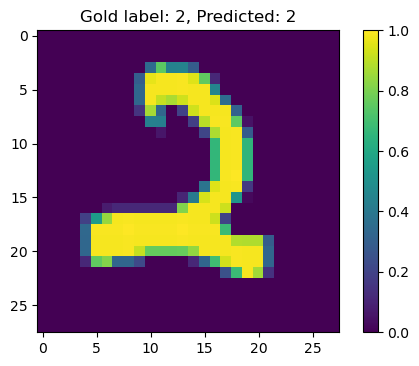

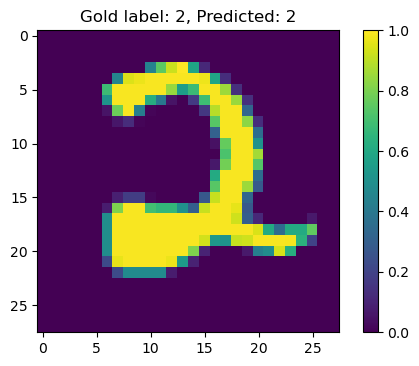

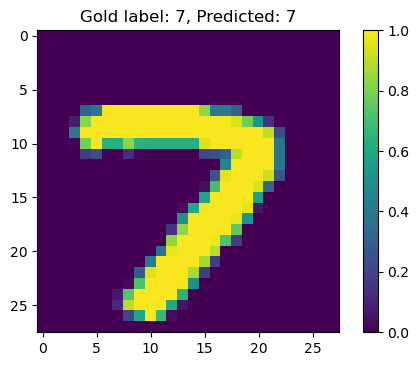

In [14]:
for i in correct_df.nlargest(3, "y_proba").index:
    mnist_plot(data["test_x"][i].reshape((28, 28)), predictions_df["y"][i], predictions_df["y_hat"][i])

In [15]:
different_df = predictions_df[(predictions_df["y"] != predictions_df["y_hat"])]
different_df.nsmallest(3, "y_proba")

,y,y_hat,y_proba
7195,5,7,0.174164
1782,8,2,0.229295
4248,2,4,0.267513


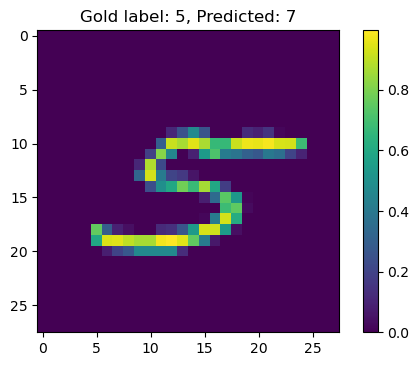

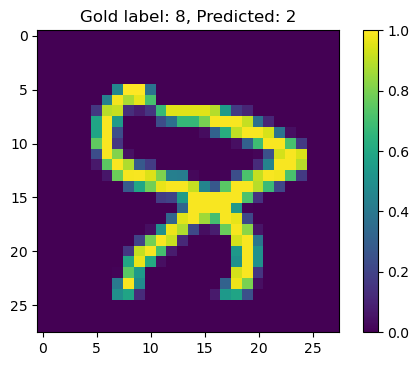

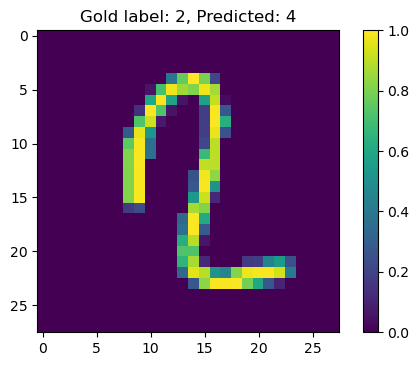

In [16]:
for i in different_df.nsmallest(3, "y_proba").index:
    mnist_plot(data["test_x"][i].reshape((28, 28)), predictions_df["y"][i], predictions_df["y_hat"][i])

### 8.5.5 多層ニューラルネットワーク

多層ニューラルネットワークを適当に構成し、(1)の実験を再度実行せよ。どのようなネットワーク構成にするかは任意である。

In [17]:
model_mlp = torch.nn.Sequential(
    torch.nn.Linear(28 * 28, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10),
    torch.nn.Softmax(dim=1)
)


optimizer_mlp = torch.optim.SGD(model_mlp.parameters(), lr=0.01)

history = []
for t in range(30):
    sum_loss = 0
    for x, y in loader:
        loss = loss_function(y, model_mlp(x))
        sum_loss += loss.item()
        optimizer_mlp.zero_grad()
        loss.backward()
        optimizer_mlp.step()
    
    history.append(sum_loss)

<AxesSubplot:title={'center':'loss per epoch'}>

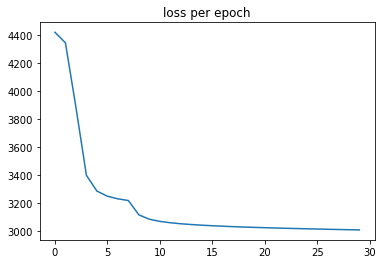

In [18]:
pd.Series(history).plot.line(title="loss per epoch")

In [19]:
from sklearn.metrics import classification_report


y_hat = None
with torch.inference_mode():
    y_proba = model_mlp(torch.from_numpy(X_test).type(dtype)).numpy()
    y_hat = np.argmax(y_proba, axis=1)
    y_max_proba = np.amax(y_proba, axis=1)

print(classification_report(data["test_y"], y_hat))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       980
           1       0.97      0.98      0.98      1135
           2       0.93      0.92      0.92      1032
           3       0.73      0.94      0.82      1010
           4       0.90      0.95      0.92       982
           5       0.00      0.00      0.00       892
           6       0.91      0.96      0.93       958
           7       0.93      0.93      0.93      1028
           8       0.67      0.94      0.78       974
           9       0.92      0.92      0.92      1009

    accuracy                           0.86     10000
   macro avg       0.78      0.85      0.81     10000
weighted avg       0.80      0.86      0.83     10000



/home/studio-lab-user/.conda/envs/mlnote/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studio-lab-user/.conda/envs/mlnote/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/studio-lab-user/.conda/envs/mlnote/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier